In [76]:
import tensorflow as tf
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

from flows import *

import os

In [77]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [78]:
mc = np.load("../data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

sim_pt =  mc['sim_jets'][:, 0]
sim_eta = mc['sim_jets'][:, 1]
sim_phi = mc['sim_jets'][:, 2]
sim_m =   mc['sim_jets'][:, 3]

sim = np.vstack([sim_pt, sim_eta, sim_phi, sim_m]).T

In [79]:
data = np.load("../data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")

dat_pt =  data['sim_jets'][:, 0]
dat_eta = data['sim_jets'][:, 1]
dat_phi = data['sim_jets'][:, 2]
dat_m =   data['sim_jets'][:, 3]

dat = np.vstack([dat_pt, dat_eta, dat_phi, dat_m]).T

In [80]:
n, d = dat.shape

In [81]:
dat_target = make_target(d)
sim_target = make_target(d)

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

In [82]:
dat_ckpt.restore('dat/ckpt-5')
sim_ckpt.restore('sim/ckpt-3')

In [83]:
dat_smp = dat_target.sample(n)
sim_smp = sim_target.sample(n)

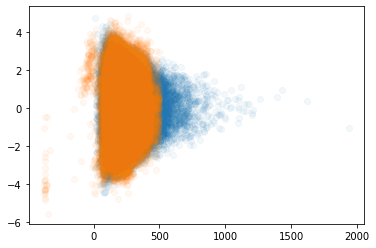

In [84]:
plt.scatter(dat[:, 0], dat[:, 1], alpha = 0.05)
plt.scatter(dat_smp[:, 0], dat_smp[:, 1], alpha = 0.05)

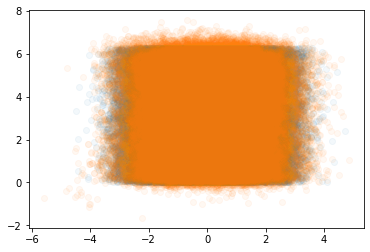

In [85]:
plt.scatter(dat[:, 1], dat[:, 2], alpha = 0.05)
plt.scatter(dat_smp[:, 1], dat_smp[:, 2], alpha = 0.05)

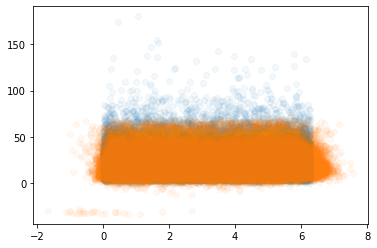

In [86]:
plt.scatter(dat[:, 2], dat[:, 3], alpha = 0.05)
plt.scatter(dat_smp[:, 2], dat_smp[:, 3], alpha = 0.05)

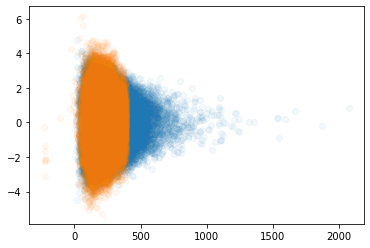

In [87]:
plt.scatter(sim[:, 0], sim[:, 1], alpha = 0.05)
plt.scatter(sim_smp[:, 0], sim_smp[:, 1], alpha = 0.05)

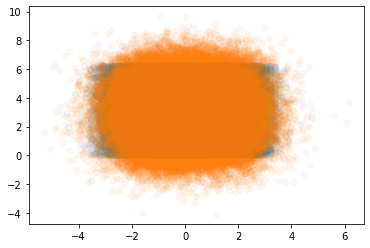

In [88]:
plt.scatter(sim[:, 1], sim[:, 2], alpha = 0.05)
plt.scatter(sim_smp[:, 1], sim_smp[:, 2], alpha = 0.05)

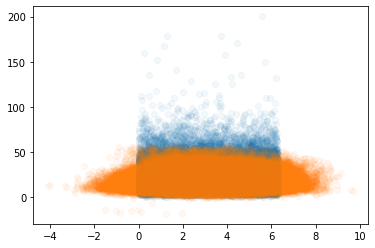

In [89]:
plt.scatter(sim[:, 2], sim[:, 3], alpha = 0.05)
plt.scatter(sim_smp[:, 2], sim_smp[:, 3], alpha = 0.05)